In [1]:
import torch
print(torch.distributed.is_available())        
print(torch.distributed.is_gloo_available())   

True
True


In [2]:
%%writefile distributed_sgd_with_profiling.py
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from datetime import timedelta
import time
import psutil


def setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    dist.init_process_group("gloo", rank=rank, world_size=world_size, timeout=timedelta(seconds=9000))


def cleanup():
    if dist.is_initialized():
        dist.destroy_process_group()


def train(rank, world_size, X_full, y_full, epochs=10000, lr=0.01):
    setup(rank, world_size)

    # Split data among processes
    N = X_full.shape[0]
    local_n = N // world_size
    start = rank * local_n
    end = start + local_n if rank != world_size - 1 else N
    X = X_full[start:end]
    y = y_full[start:end]
    converged = torch.tensor([0], dtype=torch.int32)

    # Initialize weights
    torch.manual_seed(0)
    w = torch.zeros(2, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    dist.broadcast(w, src=0)
    dist.broadcast(b, src=0)

    losses = []
    comm_times = []  # Track communication time
    cpu_usages = []  # Track CPU usage

    process = psutil.Process()  # For CPU usage

    try:
        for epoch in range(epochs):
            # Forward pass
            y_hat = X @ w + b
            loss = ((y_hat - y) ** 2).mean()
            losses.append(loss.item())

            # Backward pass
            loss.backward()

            with torch.no_grad():
                grad_w = w.grad.clone()
                grad_b = b.grad.clone()

                start_time = time.time()
                dist.all_reduce(grad_w, op=dist.ReduceOp.SUM)
                dist.all_reduce(grad_b, op=dist.ReduceOp.SUM)
                comm_time = time.time() - start_time
                comm_times.append(comm_time)

                grad_w /= world_size
                grad_b /= world_size

                w -= lr * grad_w
                b -= lr * grad_b
                w.grad.zero_()
                b.grad.zero_()

            cpu_usage = process.cpu_percent(interval=None)
            cpu_usages.append(cpu_usage)
            if loss.item() < 1e-3:
                converged[0] = 1
                print(f"Process {rank} converged at epoch {epoch+1}, Loss: {loss.item():.6f}")
            
            dist.all_reduce(converged, op=dist.ReduceOp.SUM)
            if converged.item() == world_size:
                print(f"Process {rank} exiting as all processes converged.")
                break

            if epoch % 100 == 0:
                print(f"Process {rank}, Epoch {epoch+1}, Loss: {loss.item():.6f}, "
                      f"Comm Time: {comm_time:.6f}s, CPU Usage: {cpu_usage:.2f}%")

        # Save losses, model, and stats
        torch.save(losses, f"losses_rank_{rank}.pt")
        torch.save({"w": w.detach(), "b": b.detach()}, f"model_rank_{rank}.pt")
        torch.save({"comm_times": comm_times, "cpu_usages": cpu_usages}, f"stats_rank_{rank}.pt")

    except RuntimeError as e:
        print(f"Process {rank} encountered error: {e}")
        raise
    finally:
        cleanup()


def main():
    world_size = 10
    print(f"Using {world_size} processes")
    # Generate data
    N = 2000
    torch.manual_seed(0)
    x1 = torch.linspace(-5, 5, N)
    x2 = torch.randn(N) * 2
    X = torch.stack((x1, x2), dim=1)
    X = (X - X.mean(dim=0)) / X.std(dim=0)  # Normalize
    true_w = torch.tensor([[2.0], [-3.0]])
    bias = 5.0
    y = X @ true_w + bias + torch.randn(N, 1) * 0.01

    mp.spawn(train, args=(world_size, X, y), nprocs=world_size, join=True)


if __name__ == "__main__":
    main()

Overwriting distributed_sgd_with_profiling.py


In [3]:
# !python3 distributed_linear_fit.py
!python3 distributed_sgd_with_profiling.py


Using 10 processes
Process 0, Epoch 1, Loss: 11.327743, Comm Time: 0.021784s, CPU Usage: 0.00%
Process 9, Epoch 1, Loss: 79.384521, Comm Time: 0.003057s, CPU Usage: 0.00%
Process 8, Epoch 1, Loss: 66.753235, Comm Time: 0.024551s, CPU Usage: 0.00%
Process 7, Epoch 1, Loss: 52.925903, Comm Time: 0.023157s, CPU Usage: 0.00%
Process 6, Epoch 1, Loss: 42.880177, Comm Time: 0.007411s, CPU Usage: 0.00%
Process 5, Epoch 1, Loss: 38.108700, Comm Time: 0.007735s, CPU Usage: 0.00%
Process 4, Epoch 1, Loss: 34.806690, Comm Time: 0.026441s, CPU Usage: 0.00%
Process 3, Epoch 1, Loss: 23.267553, Comm Time: 0.024107s, CPU Usage: 0.00%
Process 2, Epoch 1, Loss: 20.337486, Comm Time: 0.025199s, CPU Usage: 0.00%
Process 1, Epoch 1, Loss: 14.003335, Comm Time: 0.022610s, CPU Usage: 0.00%
Process 0, Epoch 101, Loss: 0.209452, Comm Time: 0.003235s, CPU Usage: 0.00%
Process 9, Epoch 101, Loss: 1.292602, Comm Time: 0.003211s, CPU Usage: 0.00%
Process 8, Epoch 101, Loss: 1.098853, Comm Time: 0.003201s, CPU Usa

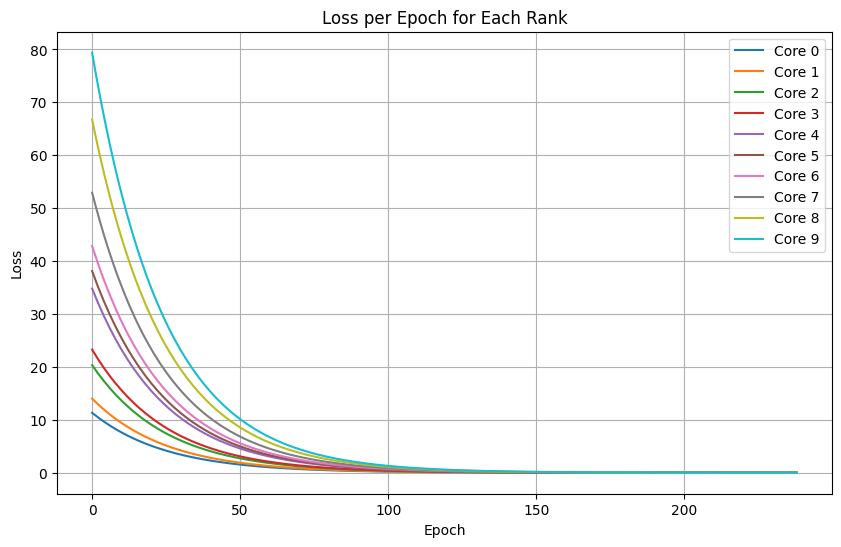

In [4]:
#load the loss pt fiels and plot them
import torch
import matplotlib.pyplot as plt
losses = []
for rank in range(10):
    try:
        loss = torch.load(f"losses_rank_{rank}.pt")
        losses.append(loss)
    except FileNotFoundError:
        print(f"Loss file for rank {rank} not found.")
plt.figure(figsize=(10, 6))
for rank, loss in enumerate(losses):
    plt.plot(loss, label=f'Core {rank}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for Each Rank')
plt.legend()
plt.grid()
plt.show()

Rank 0 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 1 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 2 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 3 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 4 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 5 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 6 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 7 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 8 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431
Rank 9 - Weights: [[1.9876646995544434], [-2.9777491092681885]], Bias: 4.9597, MSE: 0.002431

Selected model from rank 0 with MSE: 0.002431
Final model - Weights: 

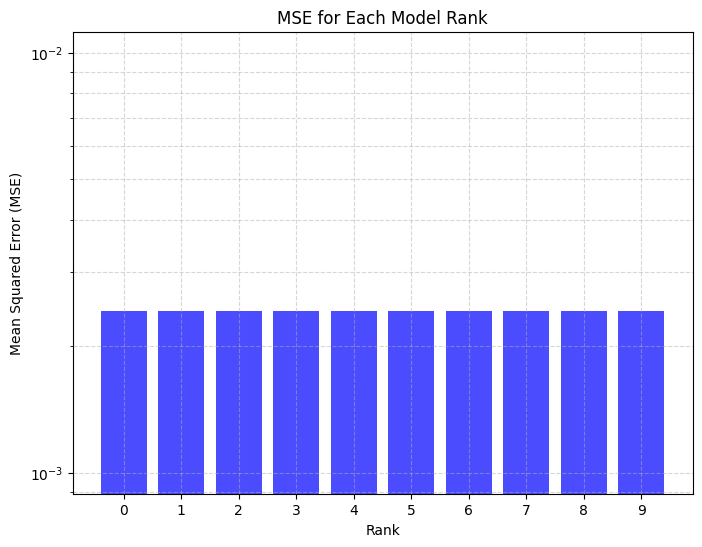

Final model MSE on test data: 0.002431


In [5]:
import torch
import matplotlib.pyplot as plt

# Generate test data (same as training)
N = 200
torch.manual_seed(0)
x1 = torch.linspace(-5, 5, N)
x2 = torch.randn(N) * 2  # Independent random values for x2
X = torch.stack((x1, x2), dim=1)  # shape (N, 2)

# Normalize input features (same as training)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Define true weights and bias
true_w = torch.tensor([[2.0], [-3.0]])  # shape (2, 1)
bias = 5.0
y = X @ true_w + bias + torch.randn(N, 1) * 0.01  # shape (N, 1)

# Load model parameters and compute MSE
mse_values = []
model_params = []
ranks = range(10)
for rank in ranks:
    try:
        params = torch.load(f"model_rank_{rank}.pt")
        w = params['w']
        b = params['b']
        # Compute predictions
        y_pred = X @ w + b
        mse = ((y_pred - y) ** 2).mean().item()
        model_params.append(params)
        mse_values.append(mse)
        print(f"Rank {rank} - Weights: {w.tolist()}, Bias: {b.item():.4f}, MSE: {mse:.6f}")
    except FileNotFoundError:
        print(f"Model file for rank {rank} not found.")
        model_params.append(None)
        mse_values.append(None)

# Select the final model (lowest MSE or rank 0 if all are similar)
valid_mses = [mse for mse in mse_values if mse is not None]
valid_ranks = [r for r, mse in zip(ranks, mse_values) if mse is not None]
if not valid_mses:
    raise ValueError("No valid model files found.")
best_rank = valid_ranks[valid_mses.index(min(valid_mses))]
final_params = model_params[best_rank]
print(f"\nSelected model from rank {best_rank} with MSE: {mse_values[best_rank]:.6f}")
print(f"Final model - Weights: {final_params['w'].tolist()}, Bias: {final_params['b'].item():.4f}")

# Save the final model
torch.save(final_params, "final_model.pt")

# Plot MSE for each rank
plt.figure(figsize=(8, 6))
plt.bar(valid_ranks, valid_mses, color='blue', alpha=0.7)
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Model Rank')
plt.yscale('log')  # Log scale for small MSE values
plt.xticks(valid_ranks)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Example: Use the final model for predictions
# Load final model
final_model = torch.load("final_model.pt")
w_final = final_model['w']
b_final = final_model['b']
# Predict on test data
y_pred_final = X @ w_final + b_final
final_mse = ((y_pred_final - y) ** 2).mean().item()
print(f"Final model MSE on test data: {final_mse:.6f}")